In [1]:
from model.swan import SWANPhase1Only
from test_model import load_config
from common.dataset import Dataset
from learner import *
from visualization.visualizer import *

In [2]:
# 'Sears tower' problem
SPLIT = 'dev'
PROBLEM_IDX = 49
BATCH_SIZE = 1

[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())
Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at google/electra-base-discriminator were

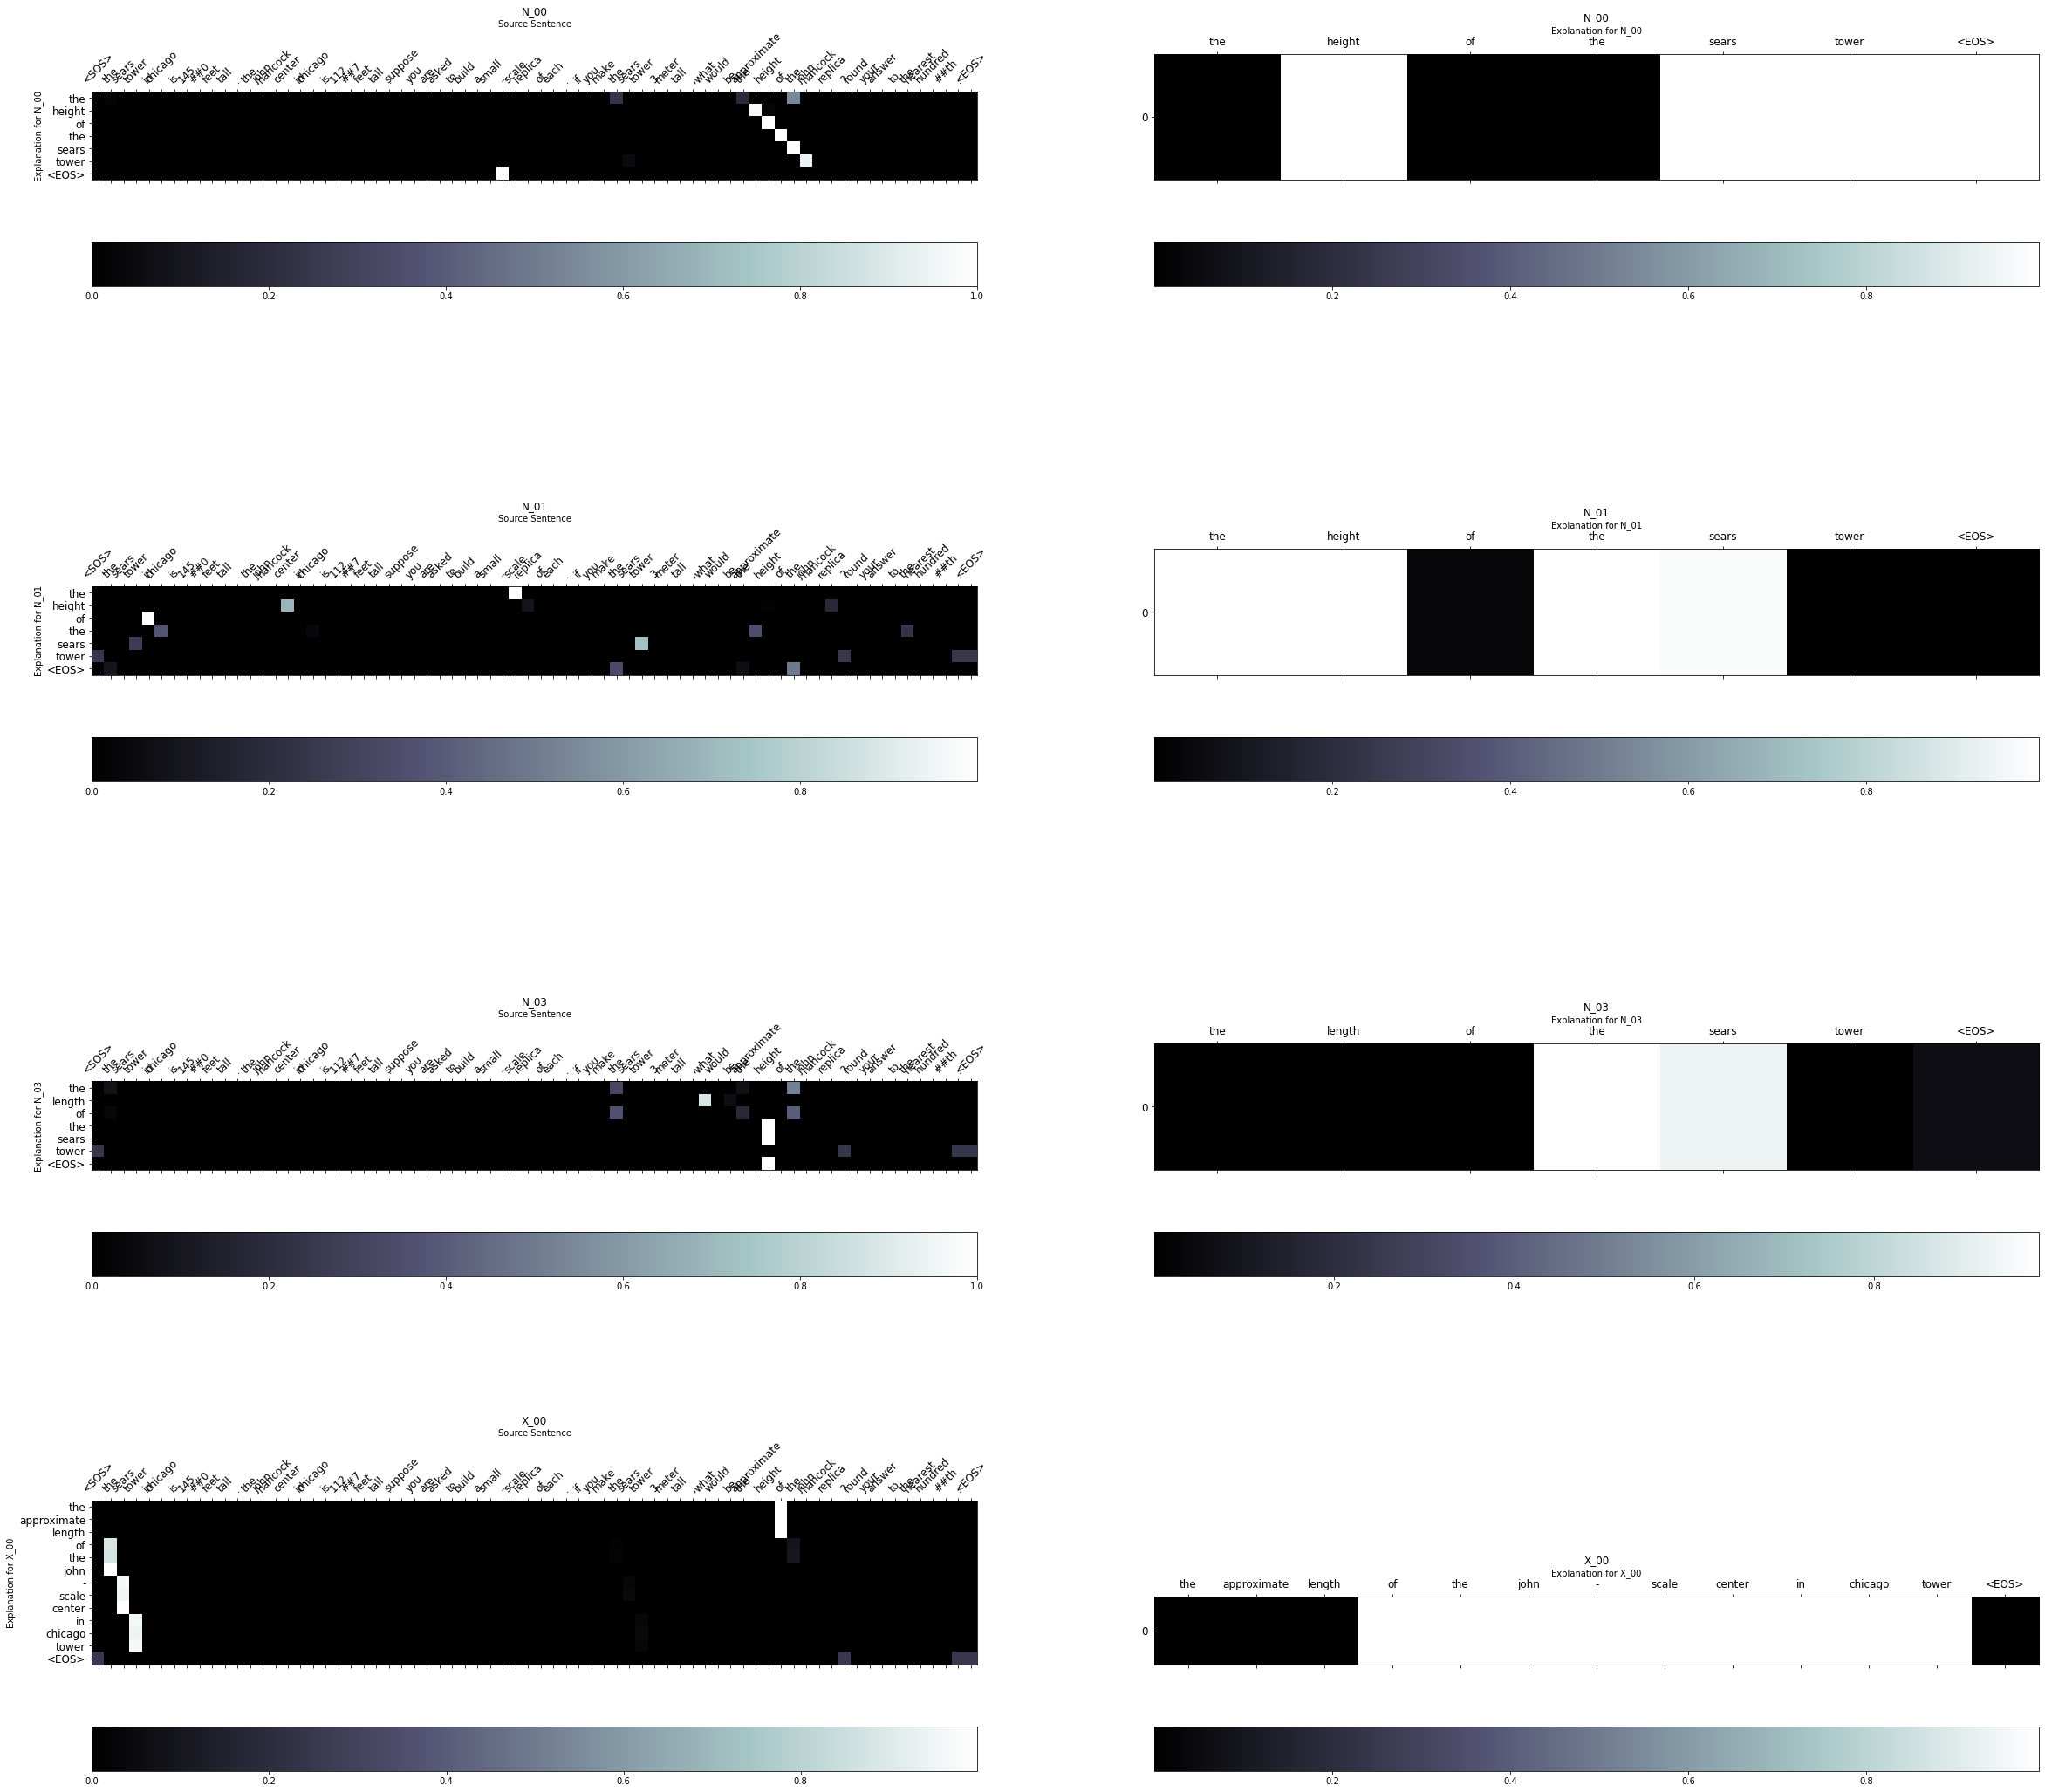

In [3]:
chpt_path = set_ckpt_path('best_SWAN_P1', from_pretrained=True)

# load pretrained
tokenizer = torch.load(chpt_path / 'tokenizer.pt') 
checkpoint = torch.load(chpt_path / 'SWANPhase1Only.pt')
config = load_config(chpt_path)

# set seed
set_seed(config['seed'])

# create model instance
nvix = SWANPhase1Only.create_or_load(path=str(chpt_path), **config)
nvix.explanation_pghead.debug = True
nvix.eval()

# load dataset
dataset_path = set_ckpt_path('dataset', from_pretrained=False)
test_data = Dataset(dataset_path / 'pen.json', number_window=3)
#load experiment files
experiment_path = set_ckpt_path('experiments', from_pretrained=False)
test_data.select_items_with_file(experiment_path / 'pen' / SPLIT)

# load (single) batch
batch = test_data.get_minibatches(batch_size=BATCH_SIZE, for_testing= True)

# get outputs from model
output = nvix(
    text=batch[PROBLEM_IDX].text.to(nvix.device),
    beam=3,
    beam_expl=1
)

explanations = output['explanation'][0].to_human_readable(tokenizer=tokenizer)

display_heatmap(
    sentence=batch[PROBLEM_IDX].text.raw[0].split(),
    explanation=explanations,
    attention=nvix.attention_scores,
    copy_probs=nvix.copy_probabilities,
    figure_name='output_test'
)